In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import OLS
from scipy.signal import periodogram

## Loading data

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


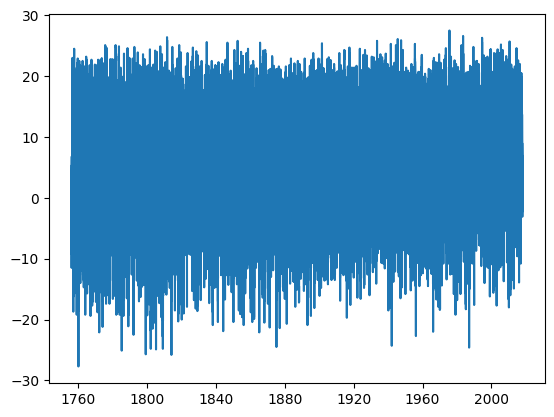

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2015-12-27,2015,12,27,-2.5
2015-12-28,2015,12,28,-1.4
2015-12-29,2015,12,29,-1.1


,Year,Month,Day,Temperature
Date,,,,
2016-01-01,2016,1,1,0.3
2016-01-02,2016,1,2,-3.6
2016-01-03,2016,1,3,-5.3
2016-01-04,2016,1,4,-6.5
2016-01-05,2016,1,5,-8.6
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


In [49]:
all_data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
all_data["Date"]=pd.to_datetime(all_data[["Year","Month","Day"]])
all_data.set_index("Date",inplace=True)
display(all_data)
plt.plot(all_data.index,all_data["Temperature"])
plt.show()
validation_data=all_data.tail(365*2+1)
data=all_data.head(-365*2-1)
display(data)
display(validation_data)

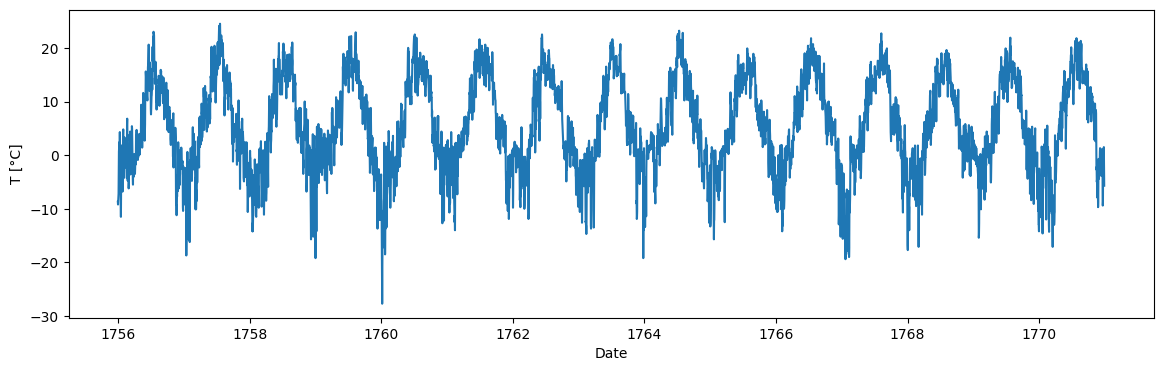

In [18]:
#Zooming in looking for periodicty
first_samples=data.head(365*15)
fig=plt.figure(figsize=(14,4))
plt.plot(first_samples.index,first_samples["Temperature"])
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.savefig("A_series")
plt.show()

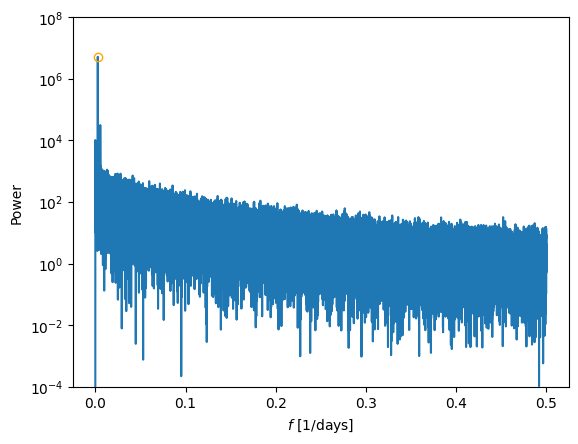

The peak is at 0.002737908448553647 which corresponds to a period of 365.2423076923077 days.


In [19]:

f, px =periodogram(data["Temperature"])
plt.plot(f,px)
plt.yscale("log")
plt.ylim([1E-4,1E8])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()
print("The peak is at",max_f,"which corresponds to a period of",1/max_f,"days.")


## Cleaning the data

0.004368603641771607
5.2355209194751176


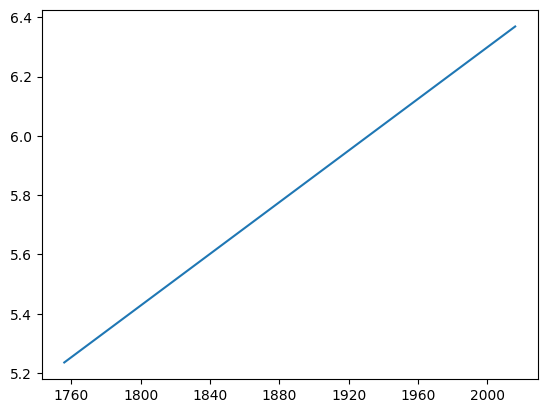

In [20]:
#Removing linear trend
data_detrended=detrend(data["Temperature"],order=1)
#We can see the linear model by
trend=data["Temperature"]-data_detrended
trend_coefficient = trend["1757-1-1"] -  trend["1756-1-1"]
trend_const = trend.iloc[0]
print(trend_coefficient)
print(trend_const)
plt.plot(trend.index,trend)
plt.show()

In [21]:
seas_decompose_4_years=seasonal_decompose(data_detrended,period=365*4+1,filt=np.zeros(1000),extrapolate_trend=1)
seas_decompose_1_year=seasonal_decompose(data_detrended,period=365,filt=np.zeros(1000),extrapolate_trend=1)

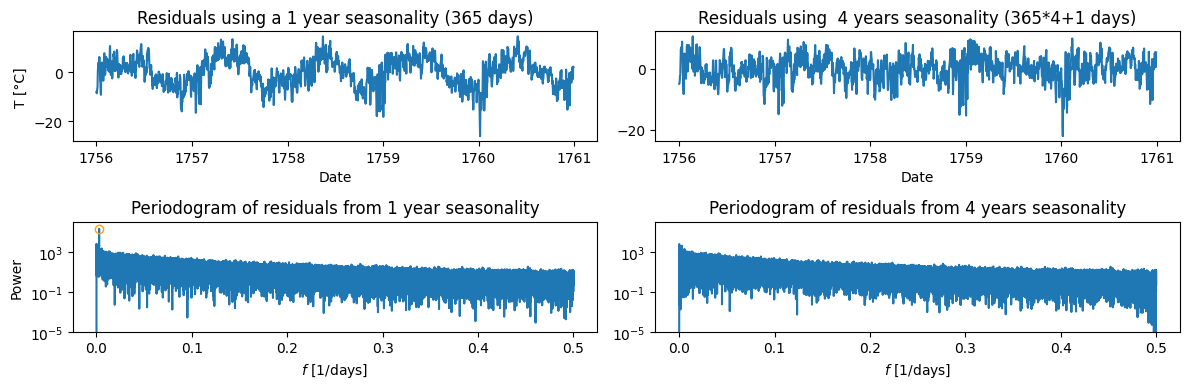

In [22]:
fig,axs=plt.subplots(2,2,figsize=(12,4))
axs[0,0].plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
axs[0,0].set_title("Residuals using a 1 year seasonality (365 days)")
axs[0,0].set_ylabel(r"T [°C]")
axs[0,0].set_xlabel(r"Date")
axs[0,1].plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
axs[0,1].set_title("Residuals using  4 years seasonality (365*4+1 days)")
axs[0,1].set_xlabel(r"Date")
f, px =periodogram(seas_decompose_1_year.resid)
axs[1,0].plot(f,px)
axs[1,0].set_title("Periodogram of residuals from 1 year seasonality")
axs[1,0].set_yscale("log")
axs[1,0].set_ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
axs[1,0].plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
axs[1,0].set_ylabel("Power")
axs[1,0].set_xlabel(r"$f$ [1/days]")
f, px =periodogram(seas_decompose_4_years.resid)
axs[1,1].plot(f,px)
axs[1,1].set_title("Periodogram of residuals from 4 years seasonality")
axs[1,1].set_yscale("log")
axs[1,1].set_ylim([1E-5,1E6])
axs[1,1].set_xlabel(r"$f$ [1/days]")
fig.tight_layout()
plt.savefig("A_periods")
plt.show()

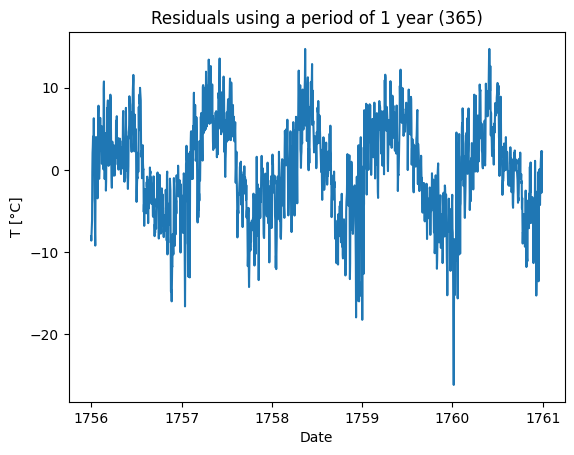

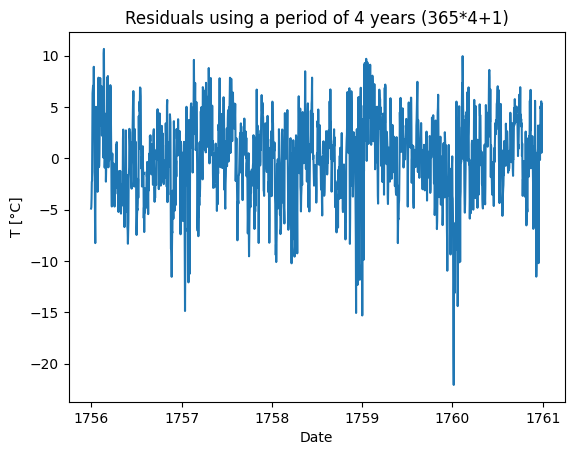

In [23]:
plt.plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
plt.title("Residuals using a period of 1 year (365)")
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.show()
plt.plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
plt.title("Residuals using a period of 4 years (365*4+1)")
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.show()

363.84291187739467


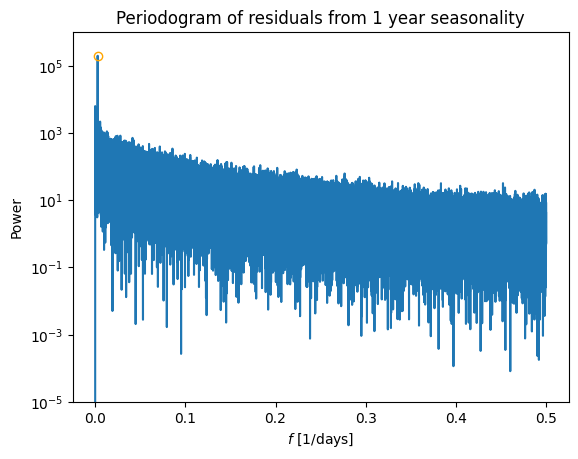

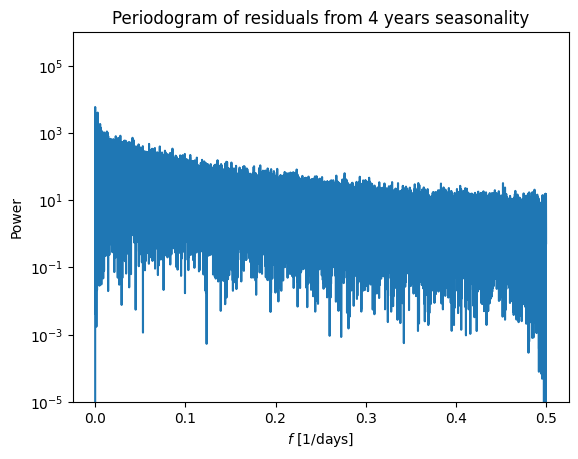

In [24]:
f, px =periodogram(seas_decompose_1_year.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 1 year seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
print(1/max_f)
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()
f, px =periodogram(seas_decompose_4_years.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 4 years seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()

In [25]:
data_cleaned=seas_decompose_4_years.resid

## Fitting ARMA Models

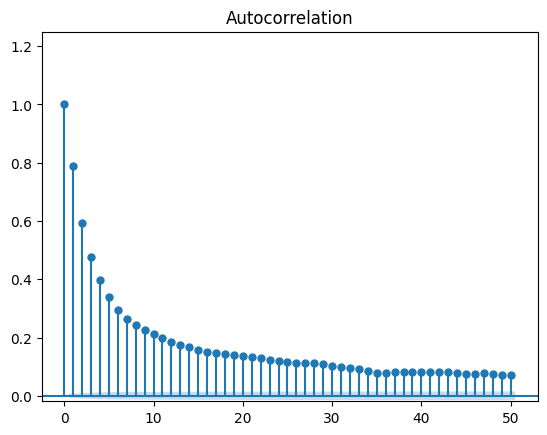

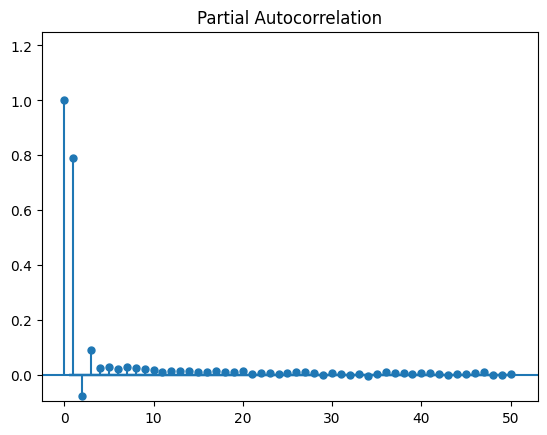

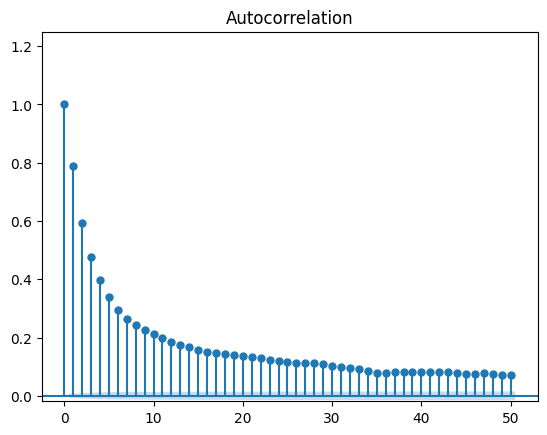

In [26]:
# TODO

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from pmdarima import auto_arima

##Plot the acf and pacf to determine the order
plot_pacf(data_cleaned, alpha = 0.05, auto_ylims = True)
plot_acf(data_cleaned, alpha = 0.05, auto_ylims= True)
##The ACF decays geometrically, indicating that an ARMA model is suitable for fitting

In [27]:
maxp=3
maxq=5

aiccs=np.zeros((maxp+1,maxq+1)) 
aics=np.zeros((maxp+1,maxq+1)) 
bics=np.zeros((maxp+1,maxq+1)) 

for p in range(0,maxp+1):
  for q in range(0,maxq+1):
    model = ARIMA(data_cleaned, order=(p, 0 ,q)).fit(method= "innovations_mle")
    
    aiccs[p,q]=model.aicc
    aics[p,q]=model.aic
    bics[p,q]=model.bic

'''
ind = np.argmin(aiccs)
model = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")
print(aiccs)
print(orders)
print(orders[ind])
'''

c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\s

'\nind = np.argmin(aiccs)\nmodel = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")\nprint(aiccs)\nprint(orders)\nprint(orders[ind])\n'

In [28]:
print(aiccs)
print(aics)
print(bics)

[[519510.81883024 458776.98232238 440678.75671305 433724.44884861
  430619.59049677 428800.86207279]
 [427075.84514906 426376.2961991  425781.85427707 425608.14222372
  425483.45208985 425402.17639285]
 [426521.01322053 426079.76679299 425239.68384214 425152.44415916
  425147.89593846 425148.12542343]
 [425762.38419958 425390.91414378 425169.7783772  425146.54432756
  425145.20295678 425149.58903917]]
[[519510.81870387 458776.98206964 440678.75629181 433724.44821674
  430619.58961215 428800.86089328]
 [427075.84489632 426376.29577786 425781.8536452  425608.1413391
  425483.45091035 425402.17487633]
 [426521.0127993  426079.76616112 425239.68295752 425152.44297966
  425147.89442193 425148.12352776]
 [425762.38356772 425390.91325916 425169.7771977  425146.54281103
  425145.2010611  425149.58672221]]
[[519529.74118911 458805.36579751 440716.60126229 433771.75442985
  430676.35706788 428867.08959163]
 [427104.22862418 426414.14074834 425829.15985831 425664.90879483
  425549.6796087  425477

In [29]:
for q in range(maxq):
    print("$q=",q,"$&",end="")
print("$q=",maxq,"$\\\\")
for p in range(maxp+1):
    print("$p=",p,"$&",end="")
    for q in range(maxq):
        print("{:.2f}".format(aiccs[p,q]),"&",end="")
    print("{:.2f}".format(aiccs[p,maxq]),"\\\\")

$q= 0 $&$q= 1 $&$q= 2 $&$q= 3 $&$q= 4 $&$q= 5 $\\
$p= 0 $&519510.82 &458776.98 &440678.76 &433724.45 &430619.59 &428800.86 \\
$p= 1 $&427075.85 &426376.30 &425781.85 &425608.14 &425483.45 &425402.18 \\
$p= 2 $&426521.01 &426079.77 &425239.68 &425152.44 &425147.90 &425148.13 \\
$p= 3 $&425762.38 &425390.91 &425169.78 &425146.54 &425145.20 &425149.59 \\


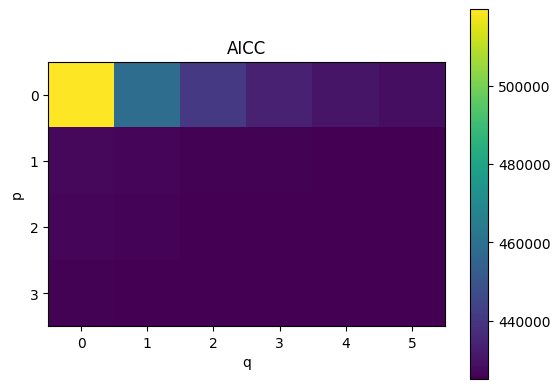

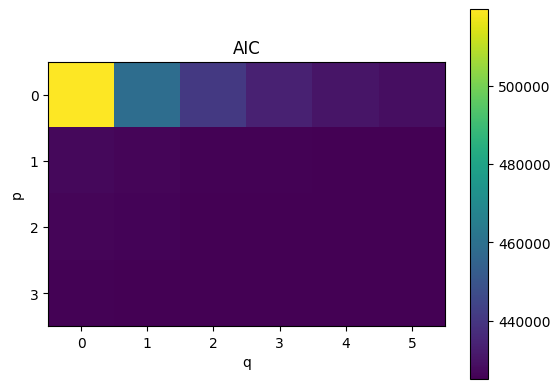

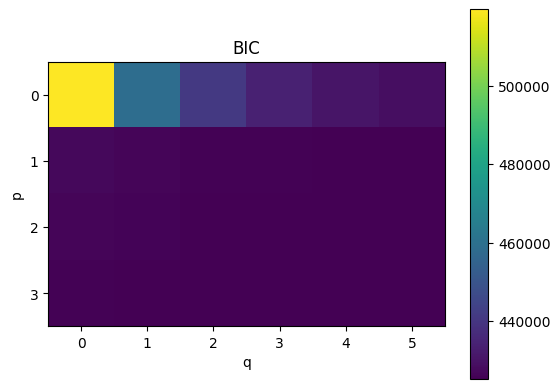

In [30]:
plt.imshow(aiccs,vmin=aiccs.min(),vmax=aiccs.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AICC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(aics,vmin=aics.min(),vmax=aics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(bics,vmin=bics.min(),vmax=bics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("BIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()

In [31]:
best_params=np.unravel_index(np.argmin(aiccs), aiccs.shape)
#best_params = (2, 2)
print("Best params:  p =",best_params[0],",  q =",best_params[1])
best_model=ARIMA(data_cleaned, order=(best_params[0], 0 ,best_params[1])).fit(method= "innovations_mle")
print("Best params using innovations")
print("ar:",best_model.arparams)
print("ma:",best_model.maparams)

Best params:  p = 3 ,  q = 4


c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best params using innovations
ar: [ 2.48058964 -2.01992817  0.53839083]
ma: [-1.63307007  0.48426447  0.19081236 -0.03433599]


In [32]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                94963
Model:                 ARIMA(3, 0, 4)   Log Likelihood             -212563.601
Date:                Wed, 01 May 2024   AIC                         425145.201
Time:                        18:54:05   BIC                         425230.352
Sample:                    01-01-1756   HQIC                        425171.103
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.061      0.016      0.987      -0.119       0.121
ar.L1          2.4806      0.085     29.245      0.000       2.314       2.647
ar.L2         -2.0199      0.145    -13.976      0.000      -2.303      -1.737
ar.L3          0.5384      0.060      8.932      0.000       0.420       0.657
ma.L1         -1.6331      0.085    -19.234      0.000      -1.799      -1.467
ma.L2          0.4843      0.073      6.626      0.000       0.341       0.628
ma.L3          0.1908      0.016     12.283      0.000       0.160       0.221
ma.L4         -0.0343      0.008     -4.273      0.000      -0.050      -0.019
sigma2         5.1494      0.018    284.068      0.000       5.114       5.185
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12143.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
best_model.test_normality('jarquebera')

array([[ 1.21433737e+04,  0.00000000e+00, -2.21686245e-01,
         4.69482029e+00]])

## Goodness of fit

In [57]:
all_data_detrended=detrend(all_data["Temperature"],order=1)
seas_decompose_4_years=seasonal_decompose(data_detrended,period=365*4+1,filt=np.zeros(1000),extrapolate_trend=1)

model2=ARIMA(all_data["Temperature"],order=(best_params[0], 0 ,best_params[1]))
res=model2.filter(best_model.params)

insample=res.predict()
validation_residuals=validation_data["Temperature"]-insample.tail(365*2+1)

c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


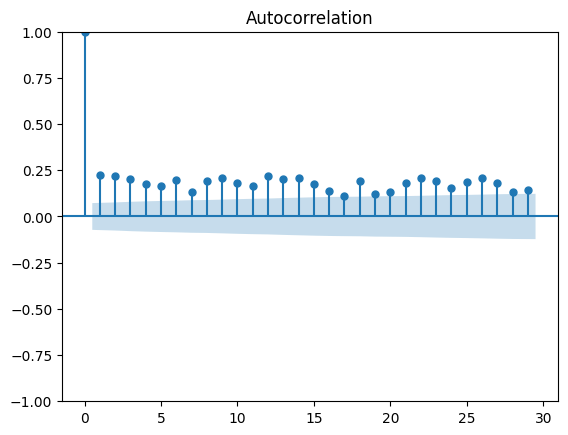

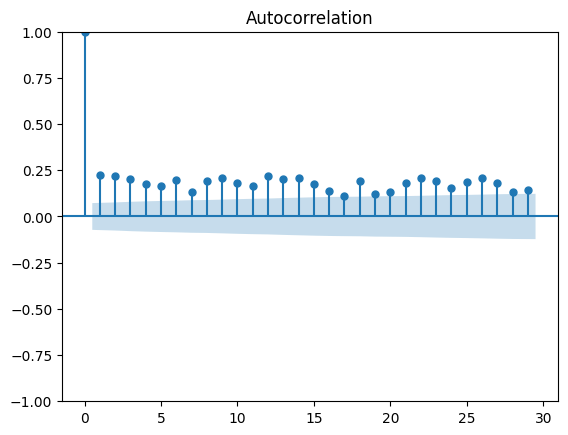

In [58]:
plot_acf(validation_residuals)

In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

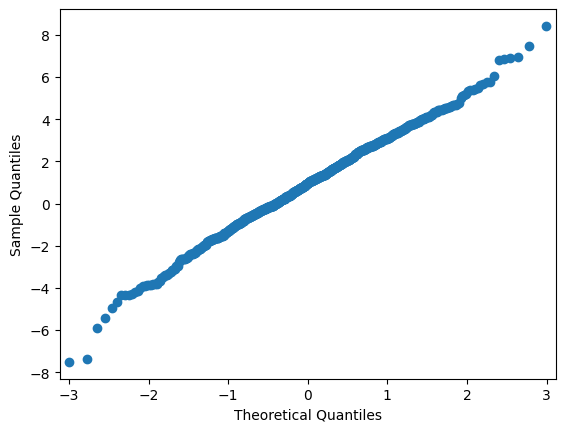

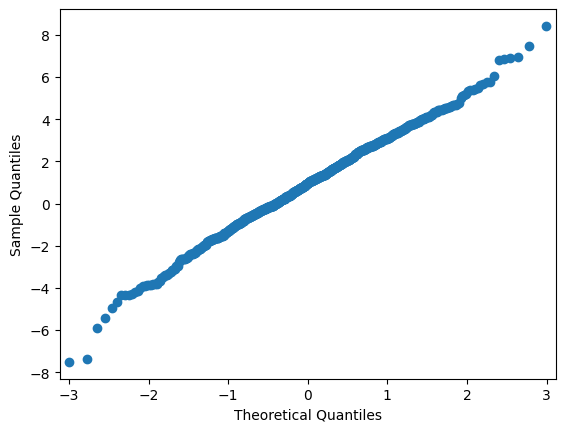

In [67]:
qqplot(validation_residuals)

In [68]:
jarque_bera(validation_residuals)

(7.071864721835823,
 0.02913158317383572,
 -0.17117964686719195,
 3.339074798662724)

In [59]:
acorr_ljungbox(validation_residuals)

,lb_stat,lb_pvalue
1,37.116746,1.112641e-09
2,73.154240,1.302443e-16
3,103.650661,2.549189e-22
4,126.715834,1.961590e-26
5,147.277020,5.070360e-30
6,175.685594,2.796582e-35
7,188.664940,2.874383e-37
8,216.463045,2.151046e-42
9,248.952937,1.659595e-48
10,273.420345,6.357965e-53


In [53]:
print(residuals)

Date
2016-01-01   -1.100484
2016-01-02   -4.164103
2016-01-03   -2.689099
2016-01-04   -2.959083
2016-01-05   -4.016959
                ...   
2017-12-27    0.662254
2017-12-28    1.686704
2017-12-29   -0.787153
2017-12-30   -0.633786
2017-12-31    1.072302
Length: 731, dtype: float64


## Forecasting

In [34]:
trend_coefficient = trend["1756-1-2"] -  trend["1756-1-1"]
seasonal = seas_decompose_4_years.seasonal
def forecast_in(start, end):
	period = 365 * 4 + 1
	forecasts = best_model.get_prediction(start = start, end = end-1).summary_frame()
	forecasts['seasonal']  = np.tile(seasonal[start%period : start%period + period].to_numpy(), int((end - start) / period) + 1 )[0 : end - start]
	forecasts['trend'] = trend_const + trend_coefficient * np.arange(start, end)
	forecasts['stationary'] = forecasts['mean']
	forecasts['mean'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_lower'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_upper'] += forecasts['seasonal'] + forecasts['trend']
	return forecasts

def forecast_out(n):
	period = 365 * 4 + 1
	forecasts = best_model.get_forecast(n).summary_frame()
	start = len(data)
	end = start + n
	forecasts['seasonal']  = np.tile(seasonal[start%period : start%period + period].to_numpy(), int((end - start) / period) + 1 )[0 : end - start]
	forecasts['trend'] = trend_const + trend_coefficient * np.arange(start, end)
	forecasts['stationary'] = forecasts['mean']
	forecasts['mean'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_lower'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_upper'] += forecasts['seasonal'] + forecasts['trend']
	return forecasts

In [35]:
forecasts = forecast_out(365*2+1)

C:\Users\ollob\AppData\Local\Temp\ipykernel_27092\4111148419.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


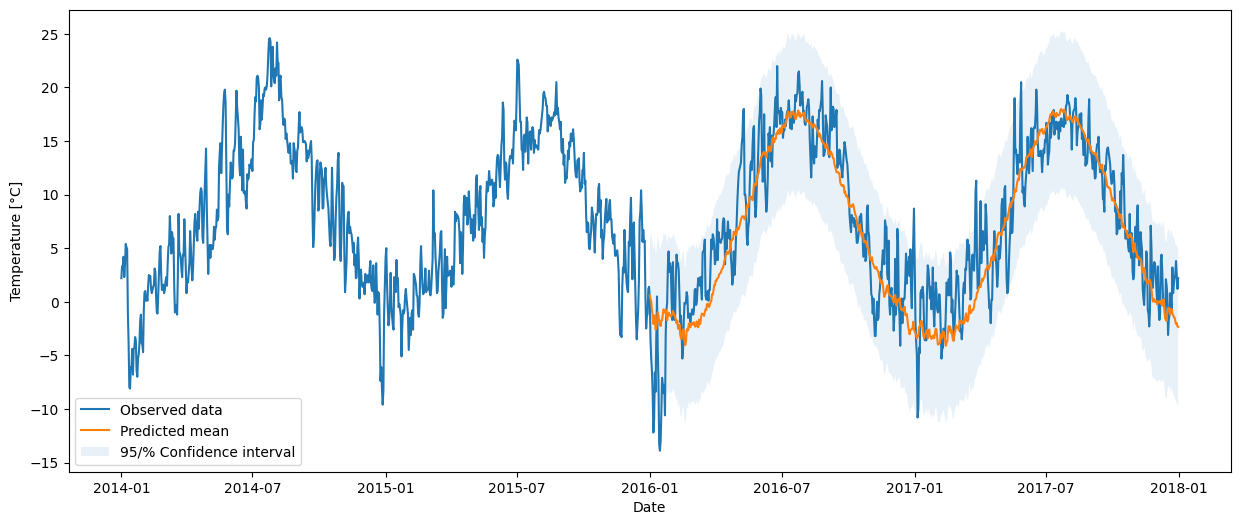

In [40]:
fig = plt.figure(figsize=(15, 6))
plt.plot(pd.concat((data.tail(365*2),validation_data)).index,pd.concat((data.tail(365*2)["Temperature"],validation_data["Temperature"])))
plt.plot(forecasts.index, forecasts['mean'])
plt.fill_between(forecasts.index, forecasts['mean_ci_lower'],forecasts['mean_ci_upper'], alpha = 0.1)
plt.legend(['Observed data','Predicted mean', '95% Confidence interval'])
plt.xlabel('Date')
plt.ylabel('Temperature [°C]')
plt.savefig("A_forecasting")
fig.show()

In [47]:
errors=(validation_data["Temperature"]-forecasts['mean']).to_numpy()
MAE=np.abs(errors).mean()
print("MAE",MAE)
RMSE=np.sqrt((errors**2).mean())
print("RMSE",RMSE)

MAE 2.6127941497159934
RMSE 3.340930882503288
